# Inspect Nucleus Training Data

Inspect and visualize data loading and pre-processing code.

https://www.kaggle.com/c/data-science-bowl-2018

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.model_selection import train_test_split

# Root directory of the project
ROOT_DIR = "./"

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
import utils
import visualize
from visualize import display_images
import model as modellib
from model import log

import nucleus

%matplotlib inline 

# Directory to save logs and trained model
LOGS_DIR = os.path.join(ROOT_DIR, "logs")

Configuring parameters. 



Using TensorFlow backend.


In [ ]:
# Comment out to reload imported modules if they change
# %load_ext autoreload
# %autoreload 2

## Configurations

In [3]:
# Dataset directory
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/")

# Use configuation from nucleus.py, but override
# image resizing so we see the real sizes here
class NoResizeConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "none"
    
config = NoResizeConfig()

## Notebook Preferences

In [77]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Load Dataset

In [7]:
# create path to dataset image directory
dataset_dir = os.path.join(DATASET_DIR, "stage1_train")
all_image_ids = os.listdir(dataset_dir)

In [11]:
# Load dataset
dataset = nucleus.NucleusDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset.load_nucleus(DATASET_DIR, "train", all_image_ids)

# Must call before using the dataset
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 32
Class Count: 2
  0. BG                                                
  1. nucleus                                           


## Display Samples

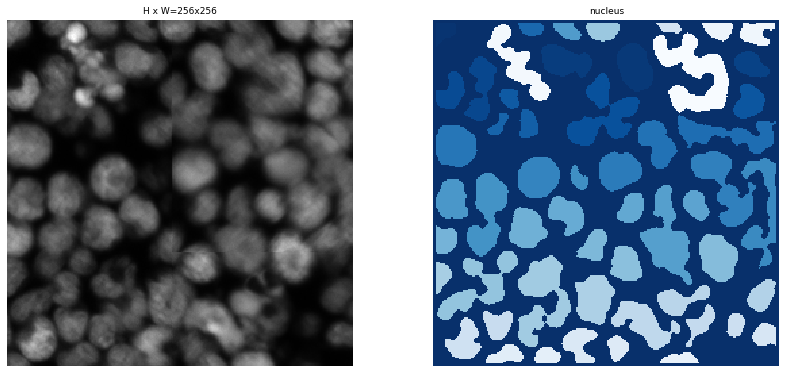

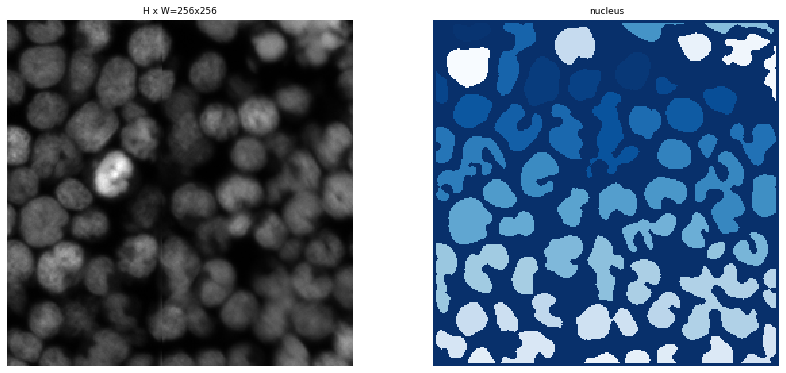

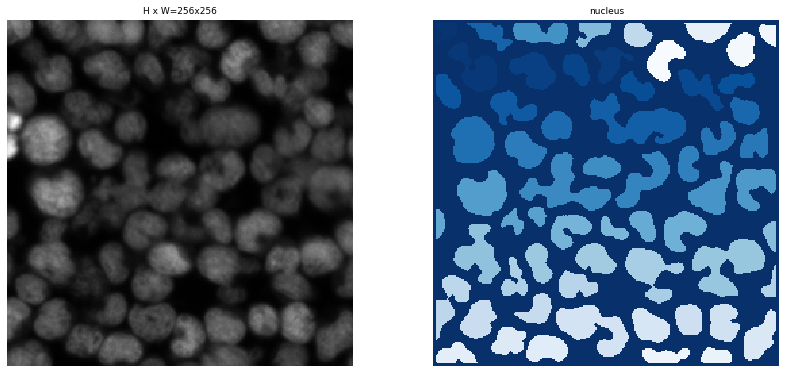

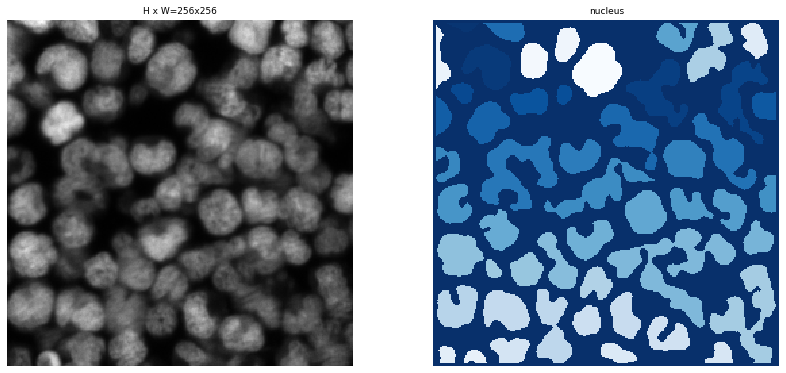

In [12]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=1)

## Dataset Stats

Loop through all images in the dataset and collect aggregate stats.

In [13]:
def image_stats(image_id):
    """Returns a dict of stats for one image."""
    image = dataset.load_image(image_id)
    mask, _ = dataset.load_mask(image_id)
    bbox = utils.extract_bboxes(mask)
    # Sanity check
    assert mask.shape[:2] == image.shape[:2]
    # Return stats dict
    return {
        "id": image_id,
        "shape": list(image.shape),
        "bbox": [[b[2] - b[0], b[3] - b[1]]
                 for b in bbox
                 # Uncomment to exclude nuclei with 1 pixel width
                 # or height (often on edges)
                 # if b[2] - b[0] > 1 and b[3] - b[1] > 1
                ],
        "color": np.mean(image, axis=(0, 1)),
    }

# Loop through the dataset and compute stats over multiple threads
# This might take a few minutes
t_start = time.time()
with concurrent.futures.ThreadPoolExecutor() as e:
    stats = list(e.map(image_stats, dataset.image_ids))
t_total = time.time() - t_start
print("Total time: {:.1f} seconds".format(t_total))

Total time: 2.5 seconds


### Image Size Stats

Image Count:  32
Height  mean: 256.00  median: 256.00  min: 256.00  max: 256.00
Width   mean: 256.00  median: 256.00  min: 256.00  max: 256.00
Color   mean (RGB): 60.34 60.34 60.34


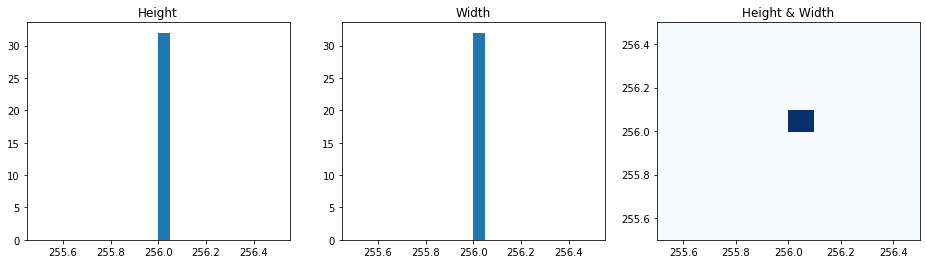

In [14]:
# Image stats
image_shape = np.array([s['shape'] for s in stats])
image_color = np.array([s['color'] for s in stats])
print("Image Count: ", image_shape.shape[0])
print("Height  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 0]), np.median(image_shape[:, 0]),
    np.min(image_shape[:, 0]), np.max(image_shape[:, 0])))
print("Width   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
    np.mean(image_shape[:, 1]), np.median(image_shape[:, 1]),
    np.min(image_shape[:, 1]), np.max(image_shape[:, 1])))
print("Color   mean (RGB): {:.2f} {:.2f} {:.2f}".format(*np.mean(image_color, axis=0)))

# Histograms
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].set_title("Height")
_ = ax[0].hist(image_shape[:, 0], bins=20)
ax[1].set_title("Width")
_ = ax[1].hist(image_shape[:, 1], bins=20)
ax[2].set_title("Height & Width")
_ = ax[2].hist2d(image_shape[:, 1], image_shape[:, 0], bins=10, cmap="Blues")

### Nuclei per Image Stats

Nuclei/Image
Image area <=  256**2:  mean: 56.9  median: 55.5  min: 35.0  max: 79.0
Image area <= 600.0**2: None
Image area <= 1300.0**2: None


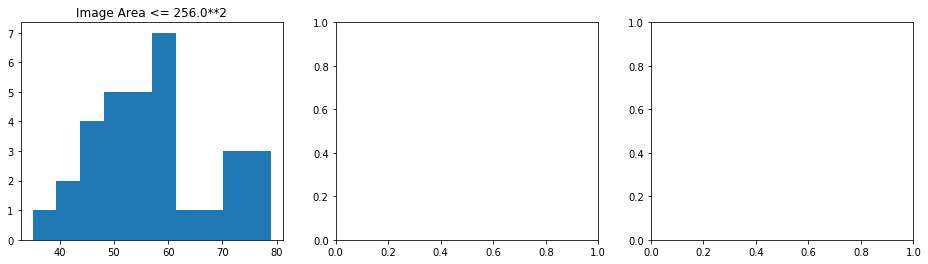

In [23]:
# Segment by image area
image_area_bins = [256**2, 600**2, 1300**2]

print("Nuclei/Image")
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nuclei_per_image = np.array([len(s['bbox']) 
                                 for s in stats 
                                 if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area])
    area_threshold = image_area
    if len(nuclei_per_image) == 0:
        print("Image area <= {:4}**2: None".format(np.sqrt(image_area)))
        continue
    print("Image area <= {:4.0f}**2:  mean: {:.1f}  median: {:.1f}  min: {:.1f}  max: {:.1f}".format(
        np.sqrt(image_area), nuclei_per_image.mean(), np.median(nuclei_per_image), 
        nuclei_per_image.min(), nuclei_per_image.max()))
    ax[i].set_title("Image Area <= {:4}**2".format(np.sqrt(image_area)))
    _ = ax[i].hist(nuclei_per_image, bins=10)

### Nuclei Size Stats


Image Area <= 256**2
  Total Nuclei:  1822
  Nucleus Height. mean: 25.98  median: 23.00  min: 5.00  max: 137.00
  Nucleus Width.  mean: 25.60  median: 23.00  min: 5.00  max: 124.00
  Nucleus Area.   mean: 65536.00  median: 65536.00  min: 65536.00  max: 65536.00

Image Area <= 600**2
  Total Nuclei:  0


IndexError: too many indices for array

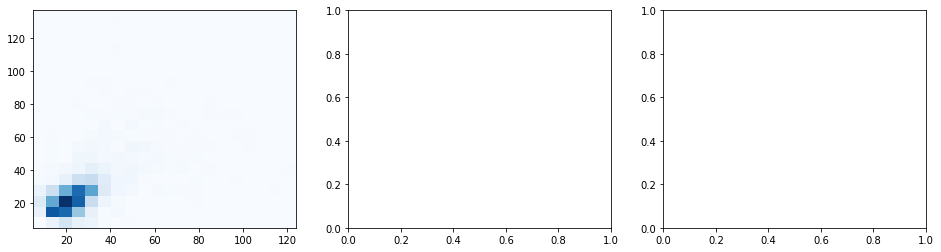

In [26]:
# Nuclei size stats
fig, ax = plt.subplots(1, len(image_area_bins), figsize=(16, 4))
area_threshold = 0
for i, image_area in enumerate(image_area_bins):
    nucleus_shape = np.array([
        b 
        for s in stats if area_threshold < (s['shape'][0] * s['shape'][1]) <= image_area
        for b in s['bbox']])
    nucleus_area = 256 * 256
    area_threshold = image_area

    print("\nImage Area <= {:.0f}**2".format(np.sqrt(image_area)))
    print("  Total Nuclei: ", nucleus_shape.shape[0])
    print("  Nucleus Height. mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 0]), np.median(nucleus_shape[:, 0]),
        np.min(nucleus_shape[:, 0]), np.max(nucleus_shape[:, 0])))
    print("  Nucleus Width.  mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_shape[:, 1]), np.median(nucleus_shape[:, 1]),
        np.min(nucleus_shape[:, 1]), np.max(nucleus_shape[:, 1])))
    print("  Nucleus Area.   mean: {:.2f}  median: {:.2f}  min: {:.2f}  max: {:.2f}".format(
        np.mean(nucleus_area), np.median(nucleus_area),
        np.min(nucleus_area), np.max(nucleus_area)))

    # Show 2D histogram
    _ = ax[i].hist2d(nucleus_shape[:, 1], nucleus_shape[:, 0], bins=20, cmap="Blues")

## Bounding Boxes
Rather than using bounding box coordinates provided by the source datasets, we compute the bounding boxes from masks instead. This allows us to handle bounding boxes consistently regardless of the source dataset, and it also makes it easier to resize, rotate, or crop images because we simply generate the bounding boxes from the updated masks rather than computing bounding box transformation for each type of image transformation.

Gathering image paths. 

image_id  18 Scan_293T_CPA_ROI_040_4x1
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
mask                     shape: (256, 256, 78)        min:    0.00000  max:    1.00000  bool
class_ids                shape: (78,)                 min:    1.00000  max:    1.00000  int32
bbox                     shape: (78, 4)               min:    2.00000  max:  254.00000  int32


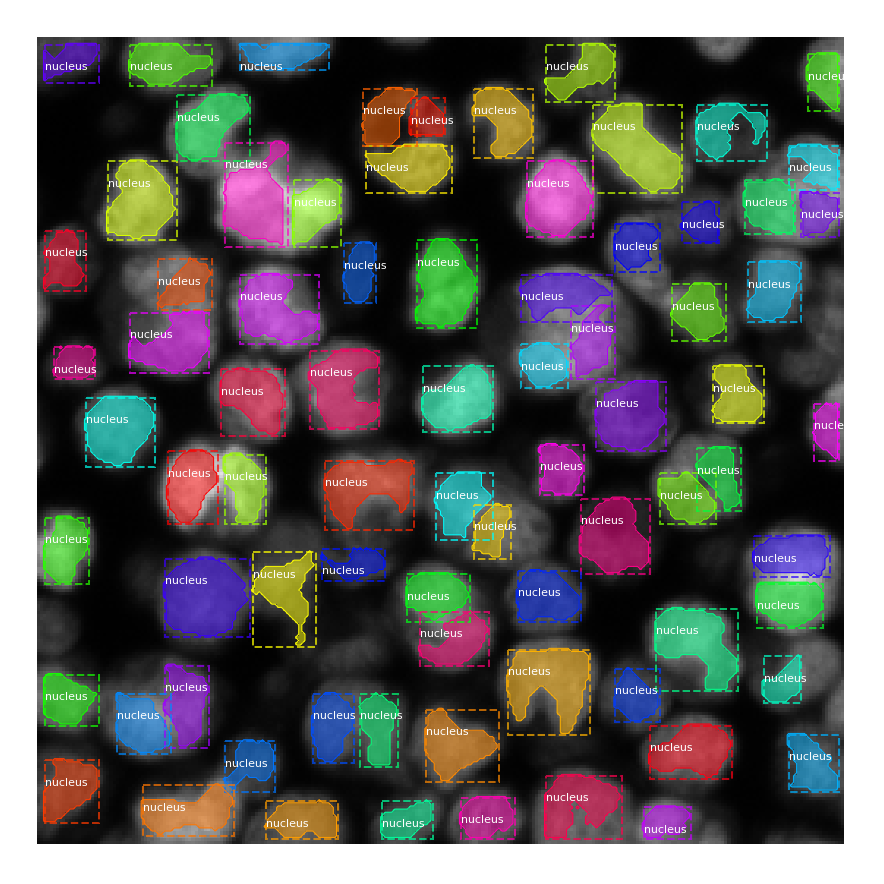

In [34]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

## Anchors

For an FPN network, the anchors must be ordered in a way that makes it easy to match anchors to the output of the convolution layers that predict anchor scores and shifts. 
* Sort by pyramid level first. All anchors of the first level, then all of the second and so on. This makes it easier to separate anchors by level.
* Within each level, sort anchors by feature map processing sequence. Typically, a convolution layer processes a feature map starting from top-left and moving right row by row. 
* For each feature map cell, pick any sorting order for the anchors of different ratios. Here we match the order of ratios passed to the function.

Count:  16368
Scales:  (8, 16, 32, 64, 128)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 12288
Anchors in Level 1: 3072
Anchors in Level 2: 768
Anchors in Level 3: 192
Anchors in Level 4: 48
Level 0. Anchors:  12288  Feature map Shape: [64 64]
Level 1. Anchors:   3072  Feature map Shape: [32 32]
Level 2. Anchors:    768  Feature map Shape: [16 16]
Level 3. Anchors:    192  Feature map Shape: [8 8]
Level 4. Anchors:     48  Feature map Shape: [4 4]


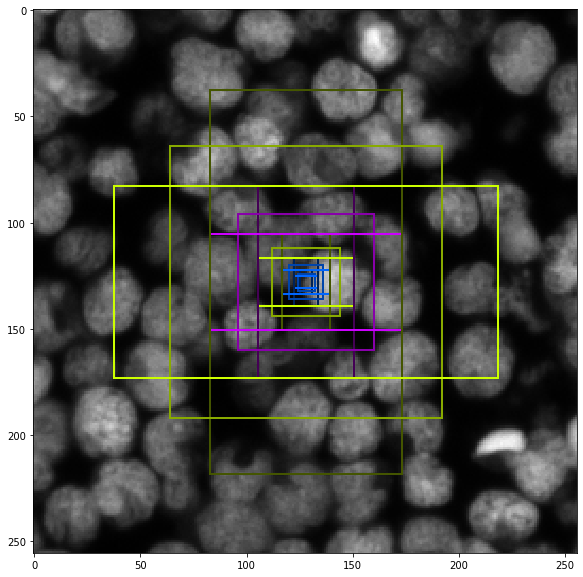

In [72]:
## Visualize anchors of one cell at the center of the feature map
class RandomCropConfig(nucleus.NucleusConfig):
    IMAGE_RESIZE_MODE = "crop"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256

crop_config = RandomCropConfig()

# Load and display random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, crop_config, image_id)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, image.shape)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(backbone_shapes)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = backbone_shapes[l][0] * backbone_shapes[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

# Display
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(backbone_shapes)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                backbone_shapes[level]))
    center_cell = backbone_shapes[level] // 2
    center_cell_index = (center_cell[0] * backbone_shapes[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * backbone_shapes[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


## Data Generator

In [65]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, crop_config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [66]:
# # Uncomment to run the generator through a lot of images
# # to catch rare errors
# for i in range(50):
#     print(i)
#     _, _ = next(g)

In [67]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = modellib.parse_image_meta(image_meta)["image_id"][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

rois                     shape: (4, 128, 4)           min:    0.00000  max:  255.00000  int32
mrcnn_class_ids          shape: (4, 128, 1)           min:    0.00000  max:    1.00000  int32
mrcnn_bbox               shape: (4, 128, 2, 4)        min:   -4.16667  max:    3.30699  float32
mrcnn_mask               shape: (4, 128, 28, 28, 2)   min:    0.00000  max:    1.00000  float32
gt_class_ids             shape: (4, 200)              min:    0.00000  max:    1.00000  int32
gt_boxes                 shape: (4, 200, 4)           min:    0.00000  max:  254.00000  int32
gt_masks                 shape: (4, 256, 256, 200)    min:    0.00000  max:    1.00000  bool
rpn_match                shape: (4, 16368, 1)         min:   -1.00000  max:    1.00000  int32
rpn_bbox                 shape: (4, 256, 4)           min:   -4.08289  max:    3.53553  float64
Gathering image paths. 

image_id:  17 Scan_293T_CPA_ROI_010_3x3


### Show Positive Anchors

anchors                  shape: (16368, 4)            min:  -90.50967  max:  282.50967  float64
refined_anchors          shape: (45, 4)               min:    1.99999  max:  244.00000  float32
Positive anchors: 45
Negative anchors: 211
Neutral anchors: 16112
BG                     : 88
nucleus                : 40


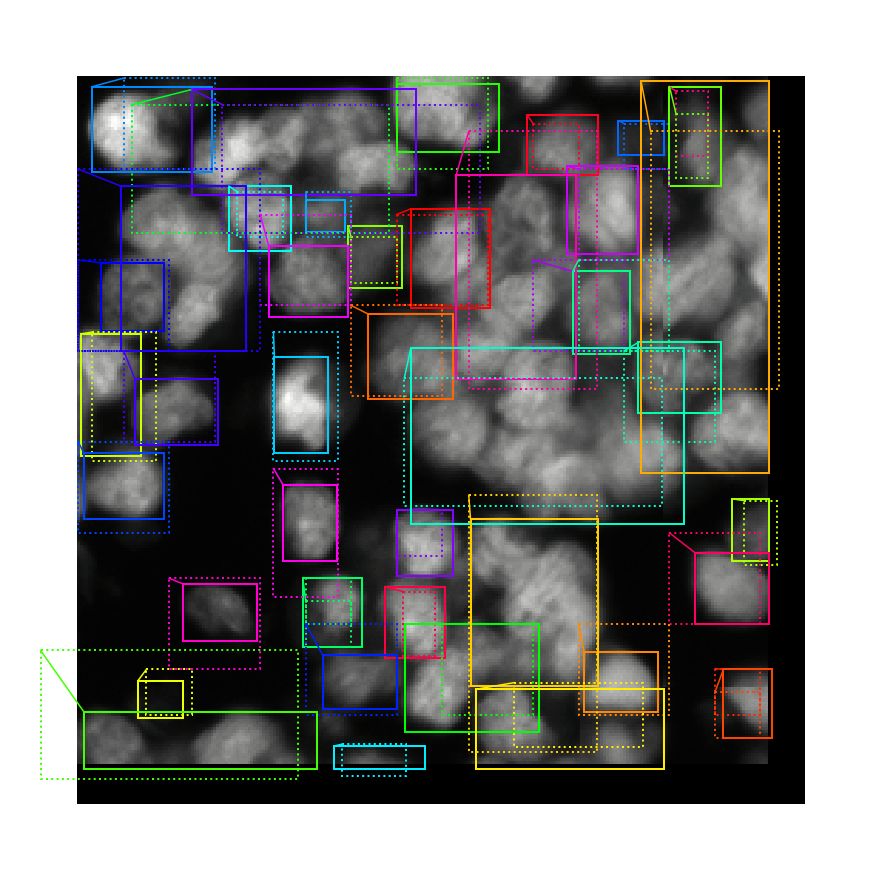

In [68]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
fig, ax = plt.subplots(1, figsize=(16, 16))
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors, ax=ax)

### Show Negative Anchors

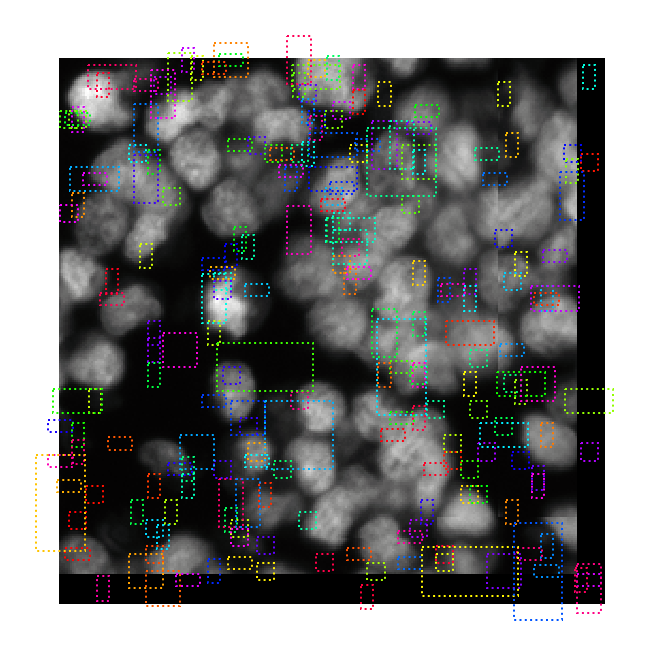

In [69]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

### Show Ignored (Neutral) Anchors 
These anchors do not contributed to training. 

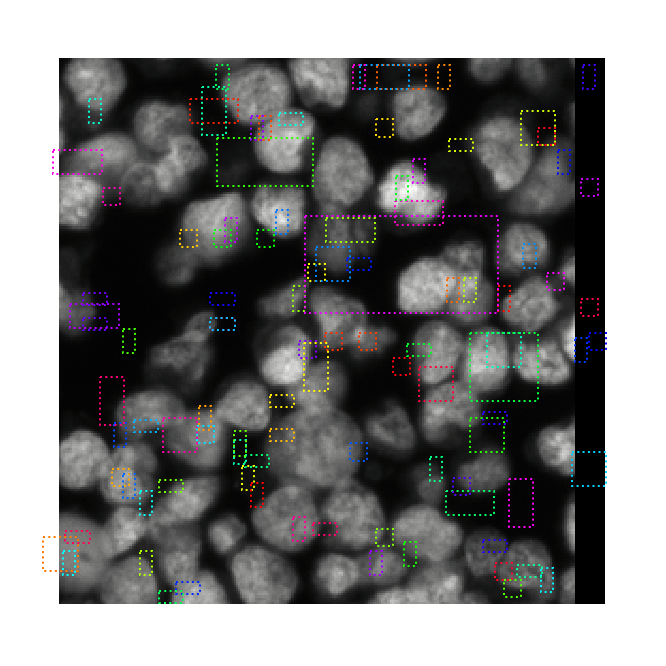

In [43]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIs

Typically, the RPN network generates region proposals (a.k.a. Regions of Interest, or ROIs). The data generator has the ability to generate proposals as well for illustration and testing purposes. These are controlled by the `random_rois` parameter.

Positive ROIs:  40
Negative ROIs:  88
Positive Ratio: 0.31
Unique ROIs: 128 out of 128


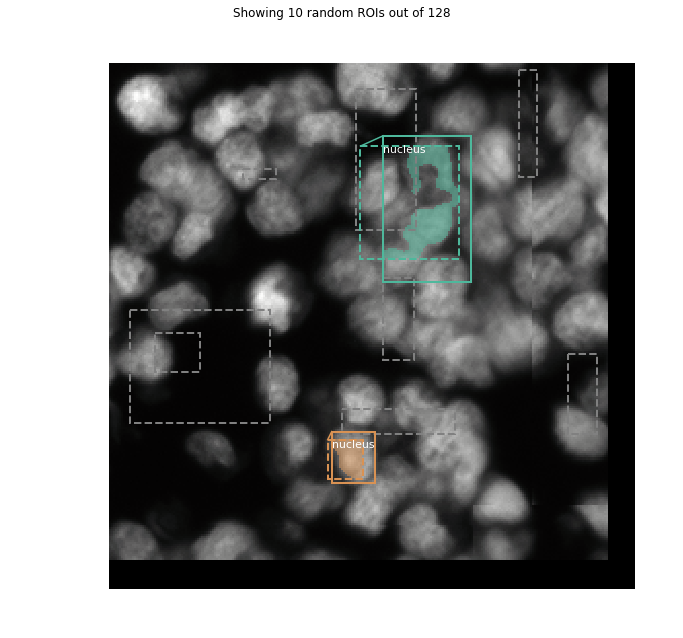

In [74]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

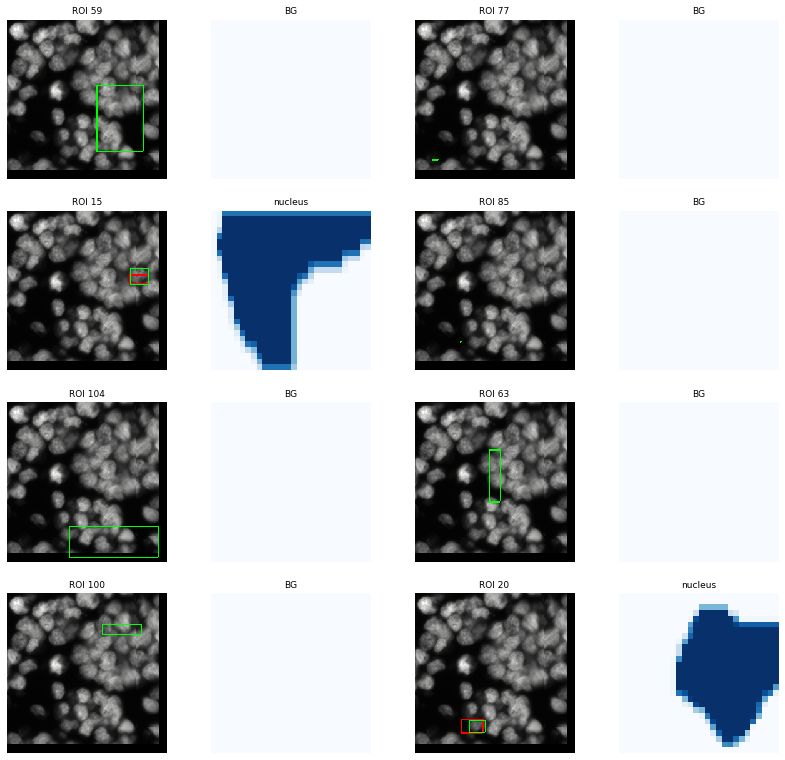

In [75]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [76]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, crop_config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
   42  0.33
Average percent: 0.33
